# Description

This notebook explores the relationship between the GM global signal and its first derivative to the iFV signal. More particularly, we see if we can reproduce some of the original observations made by Fultz et al. regarding how the signal in the FV relates to the global signal.

Observing similar relationships in our sample, provides additional evidence that we are looking at the same signal despite differences in acquisition

In [1]:
import pandas as pd
import numpy  as np
import hvplot.pandas
import os.path as osp
from bokeh.models.formatters import DatetimeTickFormatter
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind
formatter = DatetimeTickFormatter(minutes = ['%Mmin:%Ssec'])
from scipy.stats import zscore
import matplotlib.pyplot as plt
import holoviews as hv
import seaborn as sns
import panel as pn
import random
%matplotlib inline

In [2]:
from utils.basics    import get_available_runs, load_segments
from utils.variables import DATA_DIR
from nilearn.masking import apply_mask

fontsize_opts = {'title':16,'ylabel':14, 'xlabel':14, 'xticks':14, 'yticks':14,'ticks':12}

***

**Load list of scans and segments**

In [3]:
Manuscript_Runs = get_available_runs('final')
drowsy_scans    = get_available_runs(when='final', type='drowsy')
awake_scans     = get_available_runs(when='final', type='awake')
print('++ INFO: Number of Runs [All]    = %d' % len(Manuscript_Runs))
print('++ INFO: Number of Runs [Drowsy] = %d' % len(drowsy_scans))
print('++ INFO: Number of Runs [Awake]  = %d' % len(awake_scans))

++ INFO: Number of Runs [All]    = 404
++ INFO: Number of Runs [Drowsy] = 194
++ INFO: Number of Runs [Awake]  = 210


In [4]:
EC_segments = load_segments('EC',Manuscript_Runs,60)
EO_segments = load_segments('EO',Manuscript_Runs,60)

++ INFO: segment_df has shape: (234, 8)
++ INFO: segment_df has shape: (755, 8)


In [5]:
Ex_segments = pd.concat([EO_segments,EC_segments],axis=0)
print('++ INFO: Ex_segments has shape: %s' % str(Ex_segments.shape))

++ INFO: Ex_segments has shape: (989, 8)


***
**Load GM, GM_der and iFV signals for all scans**

In [6]:
%%time
N_acq = 890  # Number of volumes
TR    = 1    # Seconds
fmri_time_index = pd.timedelta_range(start='0 s', periods=N_acq, freq='{tr}ms'.format(tr=1000*TR))
GM_df = pd.DataFrame(columns=Manuscript_Runs, index=fmri_time_index)
GMd_df = pd.DataFrame(columns=Manuscript_Runs, index=fmri_time_index)
iFV_df = pd.DataFrame(columns=Manuscript_Runs, index=fmri_time_index)
for item in Manuscript_Runs:
    sbj,run  = item.split('_',1)
    GM_path  = osp.join(DATA_DIR,sbj,run,'{run}_mPP.Signal.GM.1D'.format(run=run))
    GMd_path = osp.join(DATA_DIR,sbj,run,'{run}_mPP.Signal.GM.der.1D'.format(run=run))
    iFV_path = osp.join(DATA_DIR,sbj,run,'{run}_mPP.Signal.V4lt_grp.1D'.format(run=run))
    GM_df[item]  = np.loadtxt(GM_path)
    GMd_df[item] = np.loadtxt(GMd_path)
    iFV_df[item] = np.loadtxt(iFV_path)

GM_df.columns.name='Scan ID'
GM_df.name = 'Gray Matter Signal'
GMd_df.columns.name='Scan ID'
GMd_df.name = 'Gray Matter Signal'

CPU times: user 3.41 s, sys: 90.1 ms, total: 3.5 s
Wall time: 4.07 s


**Compute -d/dt(GM) zeroing negative values**

In Fultz et al. the authors state: *"We hypothesized that the BOLD oscillations corresponded to an oscillation in cerebral blood volume and that, because of constant intracranial volume, more CSF flows into the head when less volume is occupied by the blood (25, 26). This hypothesis predicts that the CSF signal should approximately match the negative derivative of the BOLD oscillation, after setting negative values to zero (materials and methods)."*

To test if we can find the same relationship, we now change the sign of the derivative and zero the negative values. We save that version of the signal in GMd_modified_df.

In [7]:
GMd_modified_df = -GMd_df.copy()
GMd_modified_df[GMd_modified_df<0]=0

***

### 1. Amplitude of GM and iFV signal increases duing EC segments

Statement in Fultz et al. *"We observed an increase in BOLD signal amplitude in the cortical graymatter fMRI signal during sleep, as compared with wakefulness (Fig. 3A versus B and C) [mean = 3.28 dB; CI = (0.09, 6.54); P = 0.032, signed-rank test], consistent with previous reports of low-frequency BOLD fluctuations during sleep (9, 10, 24)."*

> **OBSERVATION:** Here we find an equivalent increase in both GM signal and also on the iFV signal when comparing long periods of EC to long periods of EO.

**Compute Amplitude (std across time) for these two signals separately for long EO and EC segments**

In [8]:
%%time
aux_gm_amps,aux_ifv_amps = [],[]
for r,row in Ex_segments.iterrows():
    aux_onset, aux_offset, aux_run, aux_suuid, aux_type = int(row['Onset']), int(row['Offset']), row['Run'], row['Segment_UUID'], row['Type']
    aux_gm  = GM_df.reset_index(drop=True).loc[aux_onset:aux_offset,aux_run]
    aux_ifv = iFV_df.reset_index(drop=True).loc[aux_onset:aux_offset,aux_run]
    aux_gm_amps.append(aux_gm.std())
    aux_ifv_amps.append(aux_ifv.std())
Ex_segments['GM_Amplitude'] = aux_gm_amps
Ex_segments['iFV_Amplitude'] = aux_ifv_amps

CPU times: user 8.7 s, sys: 38.6 ms, total: 8.73 s
Wall time: 8.75 s


**Create Violin-Plots of the distributions of signals' amplitudes**

In [9]:
sgments_cmap  = {'EO':'orange','EC':'lightblue'}
fig = (Ex_segments.hvplot.box(y='GM_Amplitude',by='Type',  title='Amplitude of GM Signal',  xlabel='Segment Type', ylabel='GM Amplitude', color='Type',  cmap=sgments_cmap, fontsize=fontsize_opts, legend=False) + \
       Ex_segments.hvplot.box(y='iFV_Amplitude',by='Type', title='Amplitude of iFV Signal', xlabel='Segment Type', ylabel='iFV Amplitude', color='Type', cmap=sgments_cmap, fontsize=fontsize_opts, legend=False)).opts(toolbar=None)

In [10]:
figure = pn.pane.HoloViews(fig)

In [11]:
figure.save('./figures/GM_iFV_increase_during_EC.png')

![](./figures/GM_iFV_increase_during_EC.png)

**Tests for statistical differences between both segment types**

In [12]:
print('TTest [GM]: %s' % str(ttest_ind(Ex_segments[Ex_segments['Type']=='EC']['GM_Amplitude'],Ex_segments[Ex_segments['Type']=='EO']['GM_Amplitude'],alternative='greater')))
print('TTest [iFV]: %s' % str(ttest_ind(Ex_segments[Ex_segments['Type']=='EC']['iFV_Amplitude'],Ex_segments[Ex_segments['Type']=='EO']['iFV_Amplitude'],alternative='greater')))
print('=================================================================================')
print('MWU [GM]: %s' % str(mannwhitneyu(Ex_segments[Ex_segments['Type']=='EC']['GM_Amplitude'],Ex_segments[Ex_segments['Type']=='EO']['GM_Amplitude'],alternative='greater')))
print('MWU [iFV]: %s' % str(mannwhitneyu(Ex_segments[Ex_segments['Type']=='EC']['iFV_Amplitude'],Ex_segments[Ex_segments['Type']=='EO']['iFV_Amplitude'],alternative='greater')))

TTest [GM]: Ttest_indResult(statistic=15.958712039921457, pvalue=1.768533810954231e-51)
TTest [iFV]: Ttest_indResult(statistic=9.68403087457649, pvalue=1.49974252135784e-21)
MWU [GM]: MannwhitneyuResult(statistic=137989.0, pvalue=5.660490966629714e-39)
MWU [iFV]: MannwhitneyuResult(statistic=120441.0, pvalue=2.058510667403327e-17)


***

## 2. Relationship between GM, -dGM/dt and iFV: Plot representative Timeseries for long EC segment

Fultz et al. made two additional observations:

* *"Furthermore, the CSF signal was tightly temporally coupled to the cortical gray-matter BOLD oscillation during sleep (Fig. 3, A and B), exhibiting a strong anticorrelation (fig. S3) (maximal r = −0.48 at lag 2 s, P < 0.001, shuffling)."*

* *"Consistent with this hypothesis, the CSF time series and the thresholded derivative BOLD signals were strongly correlated (Fig. 3, D and E) (maximal r = 0.59 at lag −1.8 s; P < 0.001, shuffling)."*

**Selection of a good segment**

In [13]:
# Let's find a scan with good correlations, and then from those let's find a segment of similar duration to that reported in Fultz et al. so the figures are visualize comparable
sel = GM_df[drowsy_scans].corrwith(iFV_df[drowsy_scans]).sort_values().head(40)
EC_segments[EC_segments['Run'].isin(sel.index)].sort_values(by='Duration',ascending=False)

,Run,Type,Segment_Index,Segment_UUID,Onset,Offset,Duration,Scan_Type
6978,826353_rfMRI_REST2_AP,EC,31.0,72b9122a-b767-4b45-b489-b8e0098d0e97,476.0,890.0,414.0,Drowsy
2323,145834_rfMRI_REST4_AP,EC,7.0,4a1b6bde-7236-423d-8e25-58fdeb6f33e5,300.0,675.0,375.0,Drowsy
6025,585256_rfMRI_REST1_PA,EC,6.0,41349ded-bf47-4298-a0bb-49479d921eb4,231.0,478.0,247.0,Drowsy
5843,562345_rfMRI_REST4_AP,EC,8.0,8991ec4a-be2a-41c3-939c-669071efaaf9,623.0,843.0,220.0,Drowsy
5463,393247_rfMRI_REST1_PA,EC,22.0,ef843cb7-82ee-4499-afde-73889afea7c0,581.0,771.0,190.0,Drowsy
...,...,...,...,...,...,...,...,...
3480,175237_rfMRI_REST2_AP,EC,28.0,5cd70852-cf44-4770-82bb-b1a463ba3665,546.0,608.0,62.0,Drowsy
3481,175237_rfMRI_REST2_AP,EC,29.0,e18452f9-9133-439b-b147-706c445fcbfd,621.0,683.0,62.0,Drowsy
7387,943862_rfMRI_REST1_PA,EC,6.0,646ea924-7d98-43cb-8649-bb53cda53124,197.0,259.0,62.0,Drowsy
2067,134627_rfMRI_REST3_PA,EC,19.0,743b54a7-53b2-4ce0-bfce-2c1b3e52b985,447.0,508.0,61.0,Drowsy


**Plot GM, -dGM/dt and iFV for this sample segment**

For comparison purposes, here we also reproduce the figures from Fultz et al.

In [14]:
sample_run_idx = 5843
sample_run    = EC_segments.loc[sample_run_idx,'Run']= '943862_rfMRI_REST1_PA'
sample_onset  = EC_segments.loc[sample_run_idx,'Onset']
sample_offset = EC_segments.loc[sample_run_idx,'Offset']
print('++ Selected Sample: Run = %s | Onset = %d secs | Offset = %d secs' %(sample_run, sample_onset, sample_offset))

++ Selected Sample: Run = 943862_rfMRI_REST1_PA | Onset = 623 secs | Offset = 843 secs


In [15]:
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('xtick', labelsize=14) 
fig,axs = plt.subplots(2,1,figsize=(20,9))
# Plot GM in green
ax1 = axs[0]
GM_df[sample_run].reset_index(drop=True).plot(ax=ax1,c='g',lw=2)
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_ylabel('Gray Matter Signal',color='g')
ax1.set_ylim(-2,3)
# Plot iFV in purple
ax2 = ax1.twinx()
ax1.set_xticks([])
iFV_df[sample_run].reset_index(drop=True).plot(ax=ax2,c='m',lw=2)
ax2.set_ylabel('iFV Signal',color='m')
ax2.tick_params(axis='y', labelcolor='m')
ax1.set_xlim(sample_onset,sample_offset)
ax2.set_ylim(-7,15)

# Plot -dGM/dt in blue
ax3 = axs[1]
GMd_modified_df[sample_run].reset_index(drop=True).plot(ax=ax3,c='b',lw=2)
ax3.tick_params(axis='y', labelcolor='b')
ax3.set_ylabel('-d/dt Gray Matter Signal',color='b')
# Plot iFV in purple
ax4 = ax3.twinx()
iFV_df[sample_run].reset_index(drop=True).plot(ax=ax4,c='m',lw=2)
ax4.set_ylabel('iFV Signal',color='m')
ax4.tick_params(axis='y', labelcolor='m')
ax3.set_xlim(sample_onset,sample_offset)
ax4.set_ylim(-7,15)
ax1.set_title('(A) GM Signal and iFV Signal for a Drowsy Scan', loc='left')
ax3.set_title('(B) -d/dt GM Signal and iFV Signal for a Drowsy Scan', loc='left')
ax3.set_xlabel('Time')
plt.close()

In [16]:
fig.savefig('./figures/GM_dGM_iFV_Timeseries.png')

Row
    [0] Column
        [0] PNG(str, height=200)
        [1] PNG(str, height=200)
    [1] PNG(str, height=450)
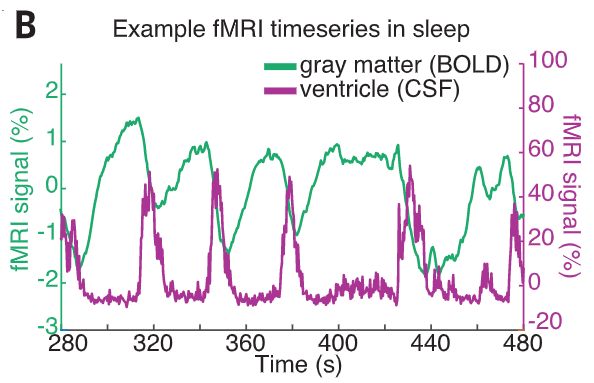
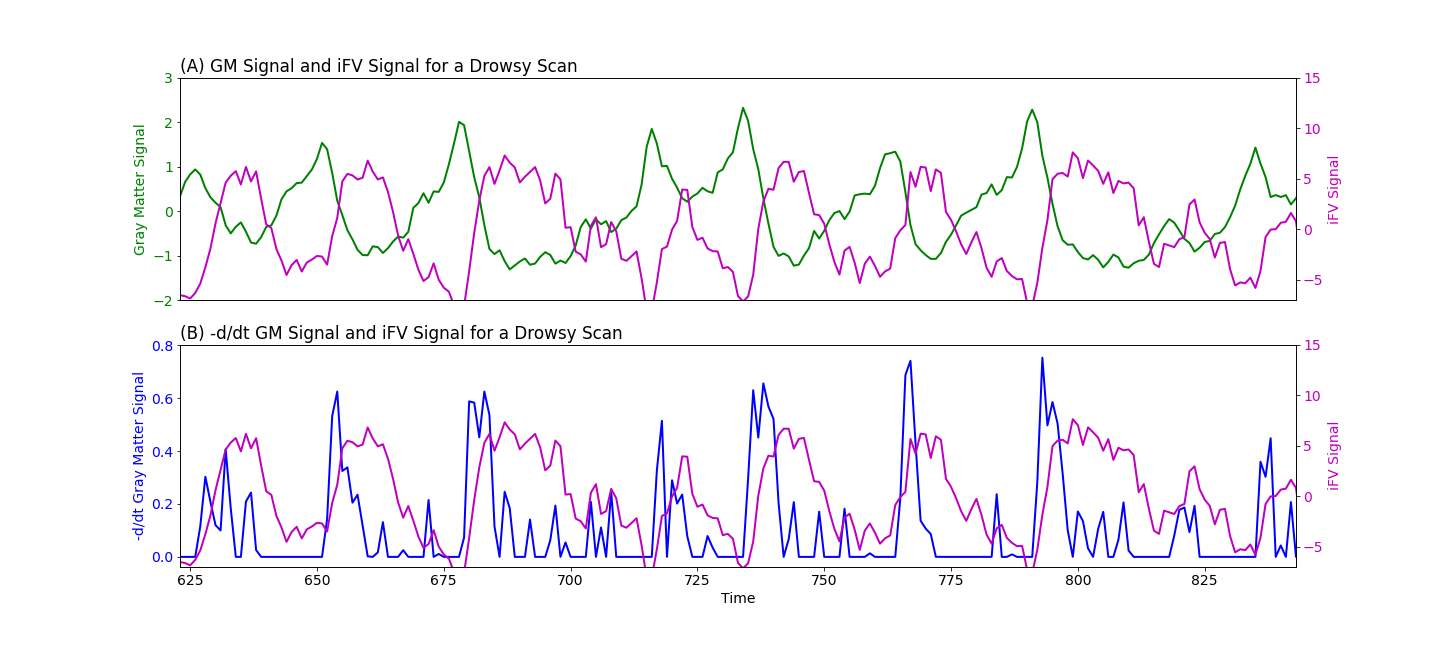
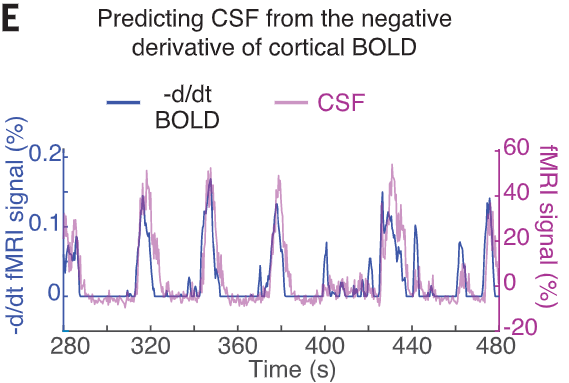

In [17]:
pn.Row(pn.Column(pn.pane.PNG('./figures/Fultz_Fig3B_Timeseres_GM_vs_iFV.png', height=200),
                 pn.pane.PNG('./figures/Fultz_Fig3E_Timeseries_dGM_vs_iFV.png', height=200)),
                 pn.pane.PNG('./figures/GM_dGM_iFV_Timeseries.png', height=450))

**Cross-correlation between GM, -dGM/dt and iFV**

In [18]:
# Work only with lags -20s to 20s (as in Fultz et al.)
lags = np.arange(41)-20
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [19]:
%%time
segments_xcorr = pd.DataFrame(index=pd.MultiIndex.from_product((EC_segments['Segment_UUID'].values,lags), names=['Segment_UUID','Lag']), columns=['xcorr_dGM_iFV','xcorr_GM_iFV'])
data = {}
for r,row in EC_segments.iterrows():
    aux_onset, aux_offset, aux_run, aux_suuid = int(row['Onset']), int(row['Offset']), row['Run'], row['Segment_UUID']
    # Case A: -d/dt GM & iFV
    data[r] = {}
    data[r]['dGM'] = GMd_modified_df.reset_index(drop=True).loc[aux_onset:aux_offset,aux_run]
    data[r]['iFV'] = iFV_df.reset_index(drop=True).loc[aux_onset:aux_offset,aux_run]
    for lag in lags:
        segments_xcorr.loc[(aux_suuid, lag),'xcorr_dGM_iFV'] = crosscorr(data[r]['dGM'], data[r]['iFV'], lag=lag)
    # Case B: GM & iFV
    data[r]['GM'] = GM_df.reset_index(drop=True).loc[aux_onset:aux_offset,aux_run]
    #y = iFV_df.reset_index(drop=True).loc[aux_onset:aux_offset,aux_run]
    for lag in lags:
        segments_xcorr.loc[(aux_suuid, lag),'xcorr_GM_iFV'] = crosscorr(data[r]['GM'], data[r]['iFV'], lag=lag)
segments_xcorr = segments_xcorr.reset_index()
segments_xcorr = segments_xcorr.infer_objects()

CPU times: user 8.26 s, sys: 815 ms, total: 9.08 s
Wall time: 9.1 s


**Shuffled version for reference confidence interval in plots**

In [20]:
%%time
num_shuffles = 1000
shuffled_segments_xcorr = pd.DataFrame(index=pd.MultiIndex.from_product((np.arange(0,num_shuffles),lags),names=['Shuffle_Num','Lag']),  columns=['xcorr_dGM_iFV','xcorr_GM_iFV'])
for shuffle_iter in np.arange(0,num_shuffles):
    x_idx = EC_segments.iloc[random.randint(0,EC_segments.shape[0]-1)].name
    y_idx = EC_segments.iloc[random.randint(0,EC_segments.shape[0]-1)].name
    GM_signal  = data[x_idx]['GM'].reset_index(drop=True)[0:59]
    dGM_signal = data[x_idx]['dGM'].reset_index(drop=True)[0:59]
    iFV_signal = data[y_idx]['iFV'].reset_index(drop=True)[0:59]
    for lag in lags:
        shuffled_segments_xcorr.loc[(shuffle_iter, lag),'xcorr_dGM_iFV'] = crosscorr(dGM_signal, iFV_signal, lag=lag)
        shuffled_segments_xcorr.loc[(shuffle_iter, lag),'xcorr_GM_iFV']  = crosscorr(GM_signal, iFV_signal, lag=lag)
shuffled_segments_xcorr = shuffled_segments_xcorr.infer_objects()

CPU times: user 31.2 s, sys: 10.7 ms, total: 31.2 s
Wall time: 31.3 s


In [21]:
max_lags_GM_iFV, max_lags_dGM_iFV = [], []
for shuffle_iter in np.arange(0,num_shuffles):
    max_lags_GM_iFV.append(shuffled_segments_xcorr.loc[shuffle_iter,:].abs().idxmax()['xcorr_GM_iFV'])
    max_lags_dGM_iFV.append(shuffled_segments_xcorr.loc[shuffle_iter,:].abs().idxmax()['xcorr_dGM_iFV'])

**BOLD-CSF Cross Correlation Plots**

In [22]:
fig, axs = plt.subplots(1,1,figsize=(4,6))
sns.lineplot(data=shuffled_segments_xcorr,x='Lag',y='xcorr_GM_iFV',color='w', lw=0, ax=axs, ci=95, err_kws={'linestyle':'dashed','linewidth':2,'facecolor':'w','edgecolor':'k', 'alpha':1})
xcorr_plot_GM2iFV = sns.lineplot(data=segments_xcorr,x='Lag',y='xcorr_GM_iFV', ax=axs, ci=95, color='darkblue')
#xcorr_plot_GM2iFV.grid()
xcorr_plot_GM2iFV.set_xlim(-20,20)
xcorr_plot_GM2iFV.set_xlabel('Lag (s)', fontsize=16)
xcorr_plot_GM2iFV.set_ylabel('R(GM,iFV)', fontsize=16)
xcorr_plot_GM2iFV.set_title('BOLD-CSF cross-correlation\n EC segments')
fig.savefig('./figures/Xcorr_GMvsiFV.png')
plt.close()

Row
    [0] PNG(str)
    [1] PNG(str, height=390)
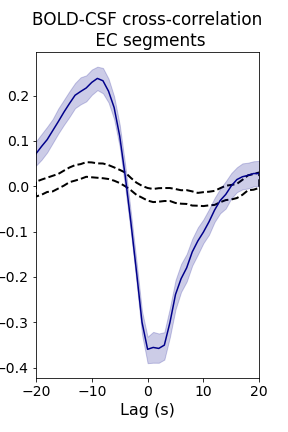
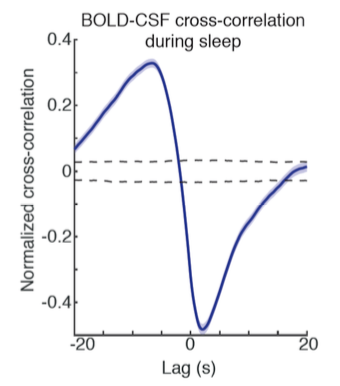

In [23]:
pn.Row(pn.pane.PNG('./figures/Fultz_FigS3_Xcorr_GM_vs_iFV.png'),
       pn.pane.PNG('./figures/Xcorr_GMvsiFV.png',height=390))

In [24]:
print('++ INFO: Maximal X Correlation Delay is %d seconds' % segments_xcorr.groupby('Lag').mean().abs().idxmax()['xcorr_GM_iFV'])

++ INFO: Maximal X Correlation Delay is 0 seconds


In [25]:
fig, axs = plt.subplots(1,1,figsize=(4,6))
sns.lineplot(data=shuffled_segments_xcorr,x='Lag',y='xcorr_dGM_iFV',color='w', lw=0, ax=axs, ci=95, err_kws={'linestyle':'dashed','linewidth':2,'facecolor':'w','edgecolor':'k', 'alpha':1})
xcorr_plot_GM2iFV = sns.lineplot(data=segments_xcorr,x='Lag',y='xcorr_dGM_iFV', ax=axs, ci=95, color='darkblue')
#xcorr_plot_GM2iFV.grid()
xcorr_plot_GM2iFV.set_xlim(-20,20)
xcorr_plot_GM2iFV.set_xlabel('Lag (s)', fontsize=16)
xcorr_plot_GM2iFV.set_ylabel('R(-dGM/dt,iFV)', fontsize=16)
xcorr_plot_GM2iFV.set_title('-d/dt GM to CSF cross-correlation\n EC segments')
fig.savefig('./figures/Xcorr_dGMvsiFV.png')
plt.close()

Row
    [0] PNG(str)
    [1] PNG(str, height=390)
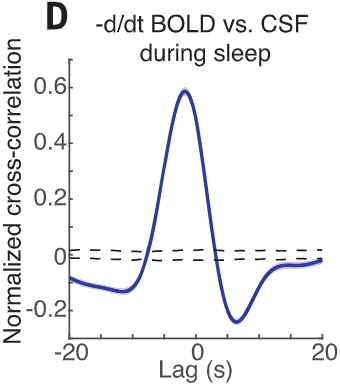
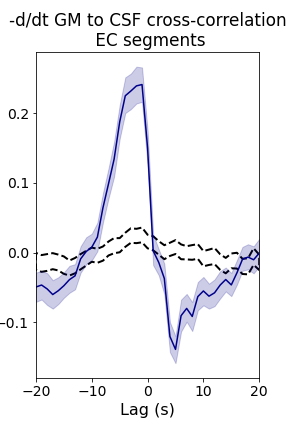

In [26]:
pn.Row(pn.pane.PNG('./figures/Fultz_Fig3D_Xcorr_dGM_vs_iFV.png'),
       pn.pane.PNG('./figures/Xcorr_dGMvsiFV.png',height=390))

In [27]:
print('++ INFO: Maximal X Correlation Delay is %d seconds' % segments_xcorr.groupby('Lag').mean().abs().idxmax()['xcorr_dGM_iFV'])

++ INFO: Maximal X Correlation Delay is -1 seconds


***
## 3. GS before and after removal of lagregressors

For us it is not only about verification of the signal properties, but also about what happens when it gets removed. The following analyses look at how the global signal changes changes with the different regression schemes inspected in this work.

In [28]:
%%time
Signals_df = {'mPP':       pd.DataFrame(columns=drowsy_scans),
              'Blur':      pd.DataFrame(columns=drowsy_scans),
              'Reference': pd.DataFrame(columns=drowsy_scans),
              'Basic':     pd.DataFrame(columns=drowsy_scans),
              'CompCor':   pd.DataFrame(columns=drowsy_scans),
              'Basic+':    pd.DataFrame(columns=drowsy_scans),
              'CompCor+':  pd.DataFrame(columns=drowsy_scans)}

for item in drowsy_scans:
    sbj,run = item.split('_',1)
    mPP_GM_path         = osp.join(DATA_DIR,sbj,run,'{run}_mPP.Signal.GM.1D'.format(run=run))
    blur_GM_path        = osp.join(DATA_DIR,sbj,run,'{run}_mPP.blur.scale.Signal.GM.1D'.format(run=run)) 
    Reference_GM_path   = osp.join(DATA_DIR,sbj,run,'{run}_Reference.Signal.GM.1D'.format(run=run)) 
    BASIC_GM_path       = osp.join(DATA_DIR,sbj,run,'{run}_BASIC.Signal.GM.1D'.format(run=run)) 
    BASICpp_GM_path     = osp.join(DATA_DIR,sbj,run,'{run}_BASICpp.Signal.GM.1D'.format(run=run)) 
    COMPCOR_GM_path     = osp.join(DATA_DIR,sbj,run,'{run}_Behzadi_COMPCOR.Signal.GM.1D'.format(run=run))
    COMPCORpp_GM_path   = osp.join(DATA_DIR,sbj,run,'{run}_Behzadi_COMPCORpp.Signal.GM.1D'.format(run=run))
    
    Signals_df['mPP'][item]       = np.loadtxt(mPP_GM_path)
    Signals_df['Blur'][item]      = np.loadtxt(blur_GM_path)
    Signals_df['Reference'][item] = np.loadtxt(Reference_GM_path)
    Signals_df['Basic'][item]     = np.loadtxt(BASIC_GM_path)
    Signals_df['Basic+'][item]    = np.loadtxt(BASICpp_GM_path)
    Signals_df['CompCor'][item]   = np.loadtxt(COMPCOR_GM_path)
    Signals_df['CompCor+'][item]  = np.loadtxt(COMPCORpp_GM_path)

CPU times: user 3.32 s, sys: 104 ms, total: 3.43 s
Wall time: 3.5 s


In [29]:
df = pd.DataFrame(index=['Reference','Basic','Basic+','CompCor','CompCor+'], columns=['Reference','Basic','Basic+','CompCor','CompCor+'])
for x in df.index:
    for y in df.columns:
        if x == y:
            df.loc[x,y] = 1
        else:
            df.loc[x,y] = Signals_df[x].corrwith(Signals_df[y]).median()

In [30]:
value_dimension = hv.Dimension('value', value_format=lambda x: '%.2f' % x)
matrix_plot = df.hvplot.heatmap(title='R(GM,GM) across regression schemes', aspect='square', fontsize=fontsize_opts, cmap='RdBu_r').opts(toolbar=None,xrotation=45, frame_width=400)
labelled_matrix_plot = matrix_plot * hv.Labels(matrix_plot, vdims=value_dimension)
pn.pane.HoloViews(labelled_matrix_plot).save('./figures/Rgm_to_gm_across_regressions.png')

![](./figures/Rgm_to_gm_across_regressions.png)